<a href="https://colab.research.google.com/github/hannanabdul55/seldonian-fairness/blob/master/logistic_regression_seldonian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seldonian Model example usage notebook
This notebook shows the usage of the `seldonian` library to train a `LogisticRegression` classifier on the [UCI Adult Income Dataset](https://archive.ics.uci.edu/ml/datasets/adult)

In [1]:
try:
    import seldonian
except:
    !pip install seldonian
import torch
import numpy as np
try:
    import shap
except:
    !pip install shap

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from seldonian.seldonian import *
from seldonian.objectives import ghat_tpr_diff, ghat_recall_rate

# Dataset
We use the `shap` library to import the preprocessed version of the Adult data. 

In [2]:
X, y = shap.datasets.adult()
X_d, y_d = shap.datasets.adult(display=True)

# Dataset statistics
Here, we plot the counts of each category of a column that you can specify in the cell below. This column will be used as the sensitive attribute in the rest of the notebook.

In [3]:
A = 'Sex'

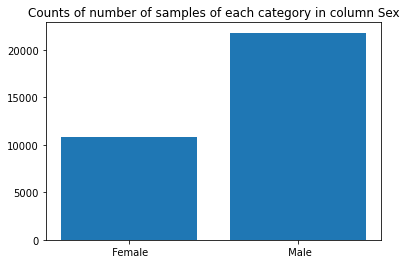

In [4]:
grps = X_d.groupby(A)
counts = {}
for k,v in grps:
    counts[k] = v.shape[0]
plt.bar(counts.keys(), counts.values())
plt.title(f"Counts of number of samples of each category in column {A}")
plt.show()

# Constraint definition

In the Seldonian Approach, the safety constraints are defined as a tuple $(g_i, \delta_i) \forall i \in m$ , where there are $m$ safety constraints.  $g: \Theta \to \mathbb{R}$ is a function that quantifies the desirability of a solution and $\delta$ is the permissive probability of returning an undesirable/unsafe solution.  

Hence, if $f(\theta, D)$ is the original minimization optimization objective where $D$ is the data, then the new Seldonian objective function is: 
$$\arg_{\theta}\min f(\theta, D) \quad \quad \quad \text{s.t. } \Pr(g_i(\theta, D) \le 0 ) \ge 1- \delta_i \quad \forall i \in m  $$  

The trianing is a 3 step-process: 
- **Dataset split**: The input training data, $D$, is split into 2 sets - the candidate set, $D_{c}$, and the safety set, $D_{s}$.
- **Candidate selection** - This is the step executed when the `fit` method is called on the Seldonian Model. This method runs the optimization objective with the safety constraints using _only_ the data $D_c$. Since $D_s$ is not available at this step, we _predict_ the upper bound on $g(\theta, D_s)$, let's call it $\hat{g}(\theta, D_c)$ using concentration inequalities like $ttest$ or _Hoeffding's_ bounds. 
- **Safety test** - This step is used to run the trained parameters, $\theta_c$ from the candidate selection step and calculate $g(\theta_c, D_s)$.  

Here we set `g_hats` as a list of $g(\theta)$'s where each item is a dictionary with the `fn` key is assigned a function callable that calculates $g_i(\theta)$ and the $\delta_i$.  

In this case, we have only one constraint which is the recall constraint on the `Sex` category in the dataset. This constraint is also known as `EqualizedOdds` constraint from [Hardt et.al 2016](https://proceedings.neurips.cc/paper/2016/file/9d2682367c3935defcb1f9e247a97c0d-Paper.pdf). The constraint is written as  

$$g(\theta) = |\Pr(f(\theta, X)=y |Y=y, A = Male) - \Pr(f(\theta, X)=y |Y=y, A = Female)| - 0.05 $$  

where `X` is the input features, `A` is the sensitive feature (`Sex` in this case) and `Y` is the target/prediction. The `0.05` is the maximum value that is permissible.  

Hence, this constraint upper bounds the absolute difference between the individual accuracy for each category of the sensitive attributes to `0.05`.  

We also split the entire dataset to a trainj and test set. Note that the test set here is _different_ from the safety set used within the Seldonian Algorithm.


In [5]:
A_idx = list(X.columns).index(A)
X = X.to_numpy()
X_tr, X_te, y_tr,y_te = train_test_split(X, y, test_size=0.3, random_state=42)
g_hats = [{
    'fn': ghat_recall_rate(A_idx, threshold=0.05),
    'delta': 0.05
}]

## Training the Seldonian Logistic Regression Model
The call to `model.fit()` run the candidate selection step and get the $\theta_c$ parameter. 

In [6]:
model = LogisticRegressionSeldonianModel(X_tr, y_tr, g_hats=g_hats, test_size=0.2, stratify=True)
model.fit()

Optimization terminated successfully.
         Current function value: 5.436154
         Iterations: 11
         Function evaluations: 4370
Optimization result: Optimization terminated successfully.


# Safety test
The call to `model._safetyTest()` runs the next step i.e.  the _safety test_ on the candidate model $\theta_c$.

In [7]:
safe = model._safetyTest()
print(f"The trained model {'failed' if safe>0 else 'passed'} the safety test.")

The trained model passed the safety test.


# Seldonian Model metrics
Here, we report the Seldonian Model's accuracy and the violation i.e. the $g(\theta_c)$ on the test set `X_te`. We can see that the $g(\theta_c) < 0$. This means the candidate $\theta_c$ _passed_ the safety test.  

In [8]:
print(f"Constrained model accuracy: {accuracy_score(y_te, model.predict(X_te))}")
print(f"Constrained model violation: {ghat_recall_rate(A_idx, threshold=0.05)(X_te, y_te, model.predict(X_te), 0.05, ub=False)} ")

Constrained model accuracy: 0.5873682055481626
Constrained model violation: -0.04533351132230197 


# Unconstrained model metrics
Now, we compare this model to an unconstrained model trained on the same dataset using scikit learns `LogisticRegression` and the same metrics are then calculated on the test set `X_te`. 

In [9]:
from sklearn.linear_model import LogisticRegression

uc_model = LogisticRegression(solver='liblinear', random_state=42).fit(X_tr, y_tr)

We can see that the unconstrained model _fails_ the safety test.

In [10]:
g_theta_test = ghat_recall_rate(A_idx, threshold=0.05)(X_te, y_te, uc_model.predict(X_te), 0.05, ub=False)
print(f"Uncontrained model accuracy: {accuracy_score(y_te, uc_model.predict(X_te))}")
print(f"Unconstrained model value of g(\\theta): {g_theta_test}")
print(f"Hence, this model {'failed' if g_theta_test >0 else 'passed'} the safety test")

Uncontrained model accuracy: 0.8401064592076978
Unconstrained model value of g(\theta): 0.06859848535359796
Hence, this model failed the safety test
